In [124]:
import libsumo as traci
import time
import random
import numpy as np
import csv
import os
import random, numpy as np
import pandas as pd, matplotlib.pyplot as plt
import csv, os
from datetime import datetime


SEED = 8
random.seed(SEED)
np.random.seed(SEED)
# Imports and configuration
# Use sumo or sumo-gui depending on your preference
SUMO_GUI_BINARY  = "sumo-gui"  # or "sumo-gui"
SUMO_BINARY  = "sumo"  # or "sumo-gui"
SUMO_CFG  = "./sumo_cfg/simulation.sumocfg"  # your .sumocfg file
SUMO_STATE = "./sumo_cfg/simulation_state.xml"  # your initial state file
SUMO_FIRST_STATE = "./sumo_cfg/simulation_first_state.xml"  # your initial state file
LOG_DIR= "logs"

# Global timing constants
REDUCE_AVG_WAIT_TIME_W, FAIRNESS_W = 0.5, 0.5 # prioritize reduce wait time
CYCLE_LENGTH_DEFAULT = 90   # s
MAX_CYCLE_LENGTH = 120      # s
MIN_CYCLE_LENGTH = 60      # s
LOST_TIME = 12              # s (amber + all-red total)
GREEN_MIN = 15             # s per direction
MIN_GREEN_SPLIT = GREEN_MIN / (MIN_CYCLE_LENGTH-LOST_TIME)  # minimum green split ratio
END_TIME = 16200
CHECK_POINT_INTERVAL = 1800

In [125]:
#Intersection metadata
# Define lane groups for metric aggregation
NS_LANES = ["1200728225#1_0", "1200728225#1_1", "1221994726#0_0", "1221994726#0_1"]  # replace with your real lane IDs
EW_LANES = ["1265822568#3_0", "1265822568#3_1", "1265822568#3_2"]

# Your target traffic light ID
TL_ID = "cluster_13075564400_13075589603_411926344"  # replace with your actual traffic light id in SUMO net

## Simulation Section

In [126]:
def reload_sumo_with_state(state_path):
    """
    Reload the current SUMO simulation from a saved state safely.
    (Wrapper around traci.load)
    Args:
        sumo_cfg (str): Path to the SUMO configuration file (.sumocfg).
        seed (int): Random seed for reproducibility.
        state_path (str): Path to the saved simulation state (.xml or .xml.gz).
        begin_time (float): Simulation time to resume from (matches saveState time).
    """
    # --- Parse snapshot time from XML header ---
    try:
        with open(state_path, "r", encoding="utf-8") as f:
            for line in f:
                if 'snapshot' in line and 'time=' in line:
                    # Extract value like time="2791.00"
                    time_str = line.split('time="')[1].split('"')[0]
                    begin_time = float(time_str)
                    break
            else:
                raise ValueError("No <snapshot> header with 'time' found in state file.")
    except Exception as e:
        raise RuntimeError(f"❌ Failed to read time from state file '{state_path}': {e}")
    
    cmd = [
        "-c", SUMO_CFG,
        "--seed", str(SEED),
        "--load-state", state_path,
        "--begin", str(begin_time)
    ]
    traci.load(cmd)

In [127]:
def find_avg_halt_range(ns_lanes, ew_lanes):
    ns_delay_proxy = ew_delay_proxy = 0
    max_avg_halt = 0
    min_avg_halt = 99999

    min_fairness = 1
    max_fairness = 0
    while traci.simulation.getTime() < END_TIME:
        ns_delay_proxy = 0
        ew_delay_proxy = 0
        for _ in range(CYCLE_LENGTH_DEFAULT):
            traci.simulationStep()
            signal_state = traci.trafficlight.getRedYellowGreenState(TL_ID)

            # Split signal state: first 5 (EW), last 7 (NS)
            ew_state = signal_state[:5]
            ns_state = signal_state[5:]

            # Detect if direction is in red
            ew_red = "r" in ew_state
            ns_red = "r" in ns_state
            # Accumulate waiting times and vehicles only when direction is red
            if ns_red:
                ns_delay_proxy += sum(traci.lane.getLastStepHaltingNumber(l) for l in ns_lanes)
            if ew_red:
                ew_delay_proxy += sum(traci.lane.getLastStepHaltingNumber(l) for l in ew_lanes)
                
            # Total average queue length
            total_avg_halt = (ns_delay_proxy + ew_delay_proxy)
             # Fairness (bounded 0–1)
            fainess = abs(ns_delay_proxy - ew_delay_proxy) / (ns_delay_proxy + ew_delay_proxy + 1e-5)
        if(total_avg_halt > max_avg_halt):
            max_avg_halt = total_avg_halt
        if(total_avg_halt < min_avg_halt):
            min_avg_halt = total_avg_halt
        if(fainess > max_fairness):
            max_fairness = fainess
        if(fainess < min_fairness):
            min_fairness = fainess

    print(f"❌ Stopping at END_TIME.")
    usable_time = CYCLE_LENGTH_DEFAULT - LOST_TIME
    
    return max_avg_halt/usable_time,min_avg_halt/usable_time,max_fairness,min_fairness

In [134]:
sumoCmd = [
    SUMO_BINARY,
    "-c", SUMO_CFG,
    "--seed", str(SEED),
]
traci.start(sumoCmd)
print(traci.trafficlight.getControlledLanes(TL_ID))
traci.simulationStep()
traci.simulation.saveState(SUMO_FIRST_STATE)
signal_state = traci.trafficlight.getRedYellowGreenState(TL_ID)
print(signal_state)

(max_avg_halt,min_avg_halt,max_fairness,min_fairness) = find_avg_halt_range(NS_LANES, EW_LANES)
print('Max avg halt', max_avg_halt)
print('Min avg halt', min_avg_halt)
print('Max fairness', max_fairness)
print('Min fairness', min_fairness)
traci.close()

('1265822568#3_0', '1265822568#3_0', '1265822568#3_1', '1265822568#3_2', '1265822568#3_2', '1200728225#1_0', '1200728225#1_1', '1200728225#1_1', '1200728225#1_1', '1221994726#0_0', '1221994726#0_0', '1221994726#0_1')
rrrrrGGggGGG
❌ Stopping at END_TIME.
Max avg halt 29.0
Min avg halt 3.0641025641025643
Max fairness 0.9999999824868655
Min fairness 0.00494699643146999


In [128]:
#Delay rate (queue area per usable second)
MIN_DELAY_RATE_PER_CYCLE = 0
MAX_DELAY_RATE_PER_CYCLE = 40

In [129]:
def apply_plan(tl_id, g_main, g_cross, amber=3, all_red=3):
    """
    Define a 2-phase signal plan (NS and EW) with amber and all-red times.
    """
    amrber_red_phase_duration = amber + all_red
    phases = [
        traci.trafficlight.Phase(g_main, "rrrrrGGggGGG"),   # NS green
        traci.trafficlight.Phase(amrber_red_phase_duration, "rrrrryyyyyyy"),    # NS amber
        traci.trafficlight.Phase(g_cross, "GGGGGrrrrrrr"),  # EW green
        traci.trafficlight.Phase(amrber_red_phase_duration, "yyyyyrrrrrrr"),    # EW amber
    ]

    logic = traci.trafficlight.Logic("custom_logic", 0, 0, phases)
    traci.trafficlight.setCompleteRedYellowGreenDefinition(tl_id, logic)

    # Metrics calculation
def cycle_metrics(ns_lanes, ew_lanes, steps):
    ns_delay_proxy = ew_delay_proxy = 0

    for _ in range(steps):
        traci.simulationStep()
        signal_state = traci.trafficlight.getRedYellowGreenState(TL_ID)

         # Split signal state: first 5 (EW), last 7 (NS)
        ew_state = signal_state[:5]
        ns_state = signal_state[5:]

        # Detect if direction is in red
        ew_red = "r" in ew_state
        ns_red = "r" in ns_state
        # Accumulate waiting times and vehicles only when direction is red
        if ns_red:
            ns_delay_proxy += sum(traci.lane.getLastStepHaltingNumber(l) for l in ns_lanes)
        if ew_red:
            ew_delay_proxy += sum(traci.lane.getLastStepHaltingNumber(l) for l in ew_lanes)
            
    # Fairness (bounded 0–1)
    O2_norm = abs(ns_delay_proxy - ew_delay_proxy) / (ns_delay_proxy + ew_delay_proxy + 1e-5)
    # Total average queue length
    delay_rate = (ns_delay_proxy + ew_delay_proxy)/(steps-LOST_TIME)
    O1_norm = (delay_rate - MIN_DELAY_RATE_PER_CYCLE) / (MAX_DELAY_RATE_PER_CYCLE - MIN_DELAY_RATE_PER_CYCLE)

    return O1_norm, O2_norm

def get_green_split(s, C):
    g_main = max(GREEN_MIN, round((C - LOST_TIME) * s))
    g_cross = max(GREEN_MIN, (C - LOST_TIME) - g_main)
    return g_main, g_cross


## Evaluate Section

In [130]:
# Evaluation function
def evaluate(s, C, isReset=True):
    try:    
        # Restore identical starting conditions before evaluating this candidate
        if isReset:
            reload_sumo_with_state(SUMO_STATE)
        g_main, g_cross = get_green_split(s, C)
        apply_plan(TL_ID, g_main, g_cross)
        steps = int(C)
        O1_norm, O2_norm = cycle_metrics(NS_LANES, EW_LANES, steps)

    except traci.exceptions.FatalTraCIError as e:
        print("⚠️ SUMO crashed during evaluation:", e)
        return C, 1  # return a default
    return O1_norm, O2_norm

def score_function(O1, O2):
    score = (REDUCE_AVG_WAIT_TIME_W * O1) + (FAIRNESS_W * O2)
    return score

# x consist of split-Cycle
def evaluate_candidate(x):
    s, C = float(x[0]), round(float(x[1]))  # round C for realism
    O1, O2 = evaluate(s, C)
    return O1, O2

def robust_evaluate(x, time_passed, n_cycles=2, λ=0.2):
    """Returns (robust_score, mean_O1, mean_O2)"""
    s, C = float(x[0]), round(float(x[1]))
    # load previous state before evaluate robust
    reload_sumo_with_state(SUMO_STATE)
    scores = []
    O1s = []
    O2s = []
    for _ in range(n_cycles):
        O1, O2 = evaluate(s, C, isReset=False)  # continue simulation
        O1s.append(O1)
        O2s.append(O2)
        scores.append(score_function(O1, O2))
    robust_score = np.mean(scores) + λ * np.std(scores)
    # return O1, O2 of first evaluation
    return robust_score, O1s[0], O2s[0]

In [131]:
from dataclasses import dataclass

@dataclass
class DEResult:
    s: float
    C: float
    O1: float
    O2: float
    score: float
    elapsed: float
    gen_history: list

### Test objective function

In [ ]:
print("\n=== Objective sweep test (fixed C=90) ===")
for s in np.linspace(0.3, 0.7, 9):
    O1, O2 = evaluate(s, 360)
    score = 0.5 * O1 + 0.5 * O2
    print(f"s={s:.2f} -> O1={O1:.3f}, O2={O2:.3f}, score={score:.3f}")

## Evolution Algorithm Section

In [121]:
 # Include previous elite as first individual (temporal continuity)
def init_population(bounds, pop_size, elite_last=None):
    pop = [np.array([random.uniform(*b) for b in bounds]) for _ in range(pop_size)]
    if elite_last is not None:
        pop[0] = np.array([elite_last[0], elite_last[1]])  # temporal continuity
    return pop

# Early stopping check using std
def early_stop_check(gen_history, patience, min_delta, elapsed, time_budget_s):
    if len(gen_history) > patience:
        recent_scores = [h[-1] for h in gen_history[-patience:]]
        score_std = np.std(recent_scores)
        if score_std < min_delta:
            print(f"Early stopping: score std {score_std:.6f} < {min_delta}")
            return True
        
    if elapsed >= time_budget_s:
            print(f"Early stopping: time lapsed {elapsed}s")
            return True
    return False

 # --- Select top-K and re-evaluate robustly
def final_robust_selection(pop, scores, K_ratio=0.1):
    K = round(len(pop) * K_ratio)
    ranked = sorted(
        [(pop[i], scores[i], score_function(*scores[i])) for i in range(len(pop))],
        key=lambda x: x[2]
    )
    topK = ranked[:K]
    evaluated = [(x, *robust_evaluate(x)) for x, _, _ in topK] #(x, robust_score, mean_O1, mean_O2)
    winner, best_robust_score, O1_first, O2_first = min(evaluated, key=lambda z: z[1])
    s_best, C_best = winner
    return s_best, C_best, O1_first, O2_first, best_robust_score
    
def reflect_in_bounds(x, lo, hi):
    if x < lo: return lo + (lo - x)
    if x > hi: return hi - (x - hi)
    return x
    
def evolve_generation(pop, scores, bounds, F_s, F_C, CR):
    scale = np.array([1.0, 1.0 / (bounds[1][1] - bounds[1][0])])  # scale by range
    F_vec = np.array([F_s, F_C]) * scale
    pop_size = len(pop)
    new_pop, new_scores = pop.copy(), scores.copy()
    dimensions = len(bounds); lower_bound, upper_bound = np.asarray(bounds).T

    for i in range(pop_size):
        idxs = [idx for idx in range(pop_size) if idx != i]
        choice_idx = np.random.choice(idxs, 3, replace=False)
        r1, r2, r3 = pop[choice_idx[0]], pop[choice_idx[1]], pop[choice_idx[2]]

         # --- Mutation ---
        mutant = r1 +  F_vec * (r2 - r3)
        # --- Reflection bounds ---
        mutant[0] = reflect_in_bounds(mutant[0], lower_bound[0], upper_bound[0])
        mutant[1] = reflect_in_bounds(mutant[1], lower_bound[1], upper_bound[1])
        
        # Crossover (ensure at least one mutant gene)
        cross_points = np.random.rand(dimensions) < CR
        if not np.any(cross_points):
            cross_points[np.random.randint(0, dimensions)] = True
        trial = np.where(cross_points, mutant, pop[i])    

        # Evaluate and selection
        O1_t, O2_t = evaluate_candidate(trial)
        O1_i, O2_i = scores[i]
        score_t = score_function(O1_t, O2_t)
        score_i = score_function(O1_i, O2_i)

        if score_t < score_i:
            new_pop[i], new_scores[i] = trial, (O1_t, O2_t)

    return new_pop, new_scores

def differential_evolution(
    elite_last=None,
    time_budget_s=60,
    pop_size=12,
    F_s=0.05,
    F_C=0.5,
    CR=0.8,
    patience=5,
    min_delta=1e-4,
):
    """
    Differential Evolution (DE/rand/1/bin)
    for 2 parameters: (s, C)
    Optimizes two objectives (O1, O2) within a strict time budget.

    Returns: DEResult(s_best, C_best, O1_best, O2_best, score_best, elapsed)
    """
    start = time.perf_counter()
    bounds = [(MIN_GREEN_SPLIT, 1-MIN_GREEN_SPLIT), (MIN_CYCLE_LENGTH, MAX_CYCLE_LENGTH)]  # (s_min, s_max), (C_min, C_max)

    pop = init_population(bounds, pop_size, elite_last)
    scores = [None] * pop_size

    # --- Evaluate initial population
    for i in range(pop_size):
        O1, O2 = evaluate_candidate(pop[i])
        scores[i] = (O1, O2)

    gen = 0
    gen_history = []  # store per-generation bests
    # --- DE optimization loop (time-bounded)
    while time.perf_counter() - start < time_budget_s:
        gen += 1
        pop, scores = evolve_generation(pop, scores, bounds, F_s, F_C, CR)

        # Summary
        best_idx = min(range(pop_size),
                       key=lambda k: score_function(scores[k][0], scores[k][1]))
        best = pop[best_idx]
        s_best, C_best = best
        O1_best, O2_best = scores[best_idx]
        score_best = score_function(O1_best, O2_best)
        elapsed = time.perf_counter() - start

        # print(f"gen {gen:02d} | t={elapsed:4.1f}s | "
        #       f"s={s_best:.3f} C={C_best:.1f} "
        #       f"O1={O1_best:.3f} O2={O2_best:.3f} score={score_best:.3f}")

        gen_history.append((elapsed, s_best, C_best, O1_best, O2_best, score_best))

        if early_stop_check(gen_history, patience, min_delta, elapsed, time_budget_s):
            break

    #TODO: skip multi cycle evaluation
    # --- Final robust evaluation
    # s_final, C_final, O1_first_eval, O2_first_eval, best_robust_score = final_robust_selection(pop, scores)
    
    # # Re-evaluate the winner once for single-cycle score
    # score_final = score_function(O1_first_eval, O2_first_eval)

    # elapsed = time.perf_counter() - start

    # return DEResult(s_final, C_final, O1_first_eval, O2_first_eval, score_final, best_robust_score, elapsed, gen_history)

    elapsed = time.perf_counter() - start

    return DEResult(s_best, C_best, O1_best, O2_best, score_best, elapsed, gen_history)


In [122]:
def log_cycle_result(
    cycle,
    s,
    C,
    O1,
    O2,
    score_best,
    elapsed_s,
    suffix="",
    out_dir=LOG_DIR,
    prefix="DE_cycle",
):
    """
    Append one cycle results to a CSV log file
    """
    # --- Create output folder
    os.makedirs(out_dir, exist_ok=True)

    # Main summary file (aggregated cycle-level results)
    summary_file = os.path.join(out_dir, f"{prefix}_summary_{suffix}.csv")
    write_header = not os.path.exists(summary_file)

    with open(summary_file, "a", newline="") as f:
        writer = csv.writer(f)
        if write_header:
            writer.writerow([
                "cycle", "s", "C", "O1", "O2",
                "score_best", "elapsed_s"
            ])
        writer.writerow([
            cycle, round(s, 3), round(C, 1), round(O1, 3), round(O2, 3),
            round(score_best, 4), round(elapsed_s, 2)
        ])

    return summary_file

In [ ]:
def seed_de_simulation(total_cycles=300):
    # Start SUMO
    sumoCmd = [
        SUMO_BINARY,
        "-c", SUMO_CFG,
        "--seed", str(SEED),
    ]
    log_suffix = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = ""

    elite = [0.5, CYCLE_LENGTH_DEFAULT]  # initial elite

    traci.start(sumoCmd)
    for cycle in range(total_cycles):
        # load default state 
        if(cycle == 0):
            traci.simulation.loadState(SUMO_FIRST_STATE)
        time_pased = traci.simulation.getTime()
        print(f"\nTime passed at cycle {cycle+1}: {time_pased}s.")
        # break on end
        if time_pased >= END_TIME:
            print(f"❌ Elapsed time exceed at: cycle {cycle+1}, stopping early.")
            break
        print(f"=== Cycle {cycle+1} (t={time_pased:.1f}s) ===")

        #  Save the current live SUMO state once
        traci.simulation.saveState(SUMO_STATE)

        #  Run DE using that snapshot as baseline
        result = differential_evolution(elite_last=elite)
        s, C, O1, O2, score_best, elapsed_s, gen_history = (
            result.s, result.C, result.O1, result.O2,
            result.score, result.elapsed, result.gen_history
        )
        elite = (s, C)

        #  Restore pre-optimization state before applying best plan
        reload_sumo_with_state(SUMO_STATE)
        print("AFTER Vehicles currently in simulation:", traci.vehicle.getIDCount())
          
        #  Apply only the *best plan* to the live SUMO world
        g_main, g_cross = get_green_split(s, C)
        apply_plan(TL_ID, g_main, g_cross)

        # Evaluate performance under fixed plan
        O1, O2 = cycle_metrics(NS_LANES, EW_LANES, int(C))
        score_best = score_function(O1, O2)
            
        #  Log and write results
        print(
            f"Chosen split={s:.2f}, C={C:.1f}, "
            f"O1={O1:.3f}, O2={O2:.3f}, score={score_best:.3f}, time={elapsed_s:.2f}s, gen={len(gen_history)}"
        )
        # Save logs
        log_file = log_cycle_result(
            cycle + 1, s, C, O1, O2, score_best, elapsed_s,
            suffix=log_suffix, out_dir="logs", prefix="traffic_DE"
        )

    traci.close()    
    print(f"\n✅ Simulation completed — results saved to {log_file}")

# Run the function
seed_de_simulation()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def visualize_pow_results(log_dir, suffix="", prefix="traffic_DE"):
    """
    Visualize core PoW evidence from your DE summary CSV.
    Expects: CSV created by log_cycle_result()
    Plots:
        1. Cycle length evolution (adaptivity)
        2. Objective trends (O1, O2)
        3. Score trend (convergence)
        4. Optimization runtime per cycle
        5. Baseline vs. EA improvement summary (optional if baseline exists)
    """
    # --- Load summary CSV
    summary_file = os.path.join(log_dir, f"{prefix}_summary_{suffix}.csv")
    if not os.path.exists(summary_file):
        print(f"❌ Summary file not found: {summary_file}")
        return

    df = pd.read_csv(summary_file)
    print(f"Loaded {len(df)} cycles from {summary_file}")

    # --- 1. Cycle length evolution
    plt.figure(figsize=(7,4))
    plt.plot(df["cycle"], df["C"], marker='o')
    plt.xlabel("Cycle #")
    plt.ylabel("Cycle length (s)")
    plt.title("Adaptive cycle length over time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 2. Objective trends
    plt.figure(figsize=(7,4))
    plt.plot(df["cycle"], df["O1"], label="Avg delay (O1)")
    plt.plot(df["cycle"], df["O2"], label="Fairness (O2)")
    plt.xlabel("Cycle #")
    plt.ylabel("Objective value")
    plt.title("Objective trends over cycles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 3. Score trend
    plt.figure(figsize=(7,4))
    plt.plot(df["cycle"], df["score_best"], label="Score (per cycle)", color='orange')
    plt.xlabel("Cycle #")
    plt.ylabel("Score")
    plt.title("Optimization score per cycle")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 4. Runtime feasibility
    plt.figure(figsize=(7,4))
    plt.plot(df["cycle"], df["elapsed_s"], label="Runtime per optimization", color='red')
    plt.axhline(y=15, color='gray', linestyle='--', label="15s real-time bound")
    plt.xlabel("Cycle #")
    plt.ylabel("Computation time (s)")
    plt.title("Optimization runtime per cycle")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 5. Summary statistics
    print("\n=== Summary statistics ===")
    print(df[["C","O1","O2","score_best","elapsed_s"]].describe().round(3))
    avg_runtime = df["elapsed_s"].mean()
    print(f"\n✅  Average runtime per DE optimization: {avg_runtime:.2f}s")
    print("✅ Visualization complete — core PoW evidence generated.")


In [ ]:
visualize_pow_results(log_dir=LOG_DIR, suffix="20251106_225623")

In [ ]:
def baseline_simulation(fixed_s=0.5, fixed_C=90, total_cycles=300):
    """
    Baseline simulation using a fixed signal plan (no optimization).
    Uses identical SUMO setup and logging as the DE version
    for direct comparison.
    """
    sumoCmd = [
        SUMO_BINARY,
        "-c", SUMO_CFG,
        "--seed", str(SEED),
    ]
    log_suffix = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = ""

    print(f"Running baseline simulation: s={fixed_s}, C={fixed_C}s for {total_cycles} cycles")

    traci.start(sumoCmd) 
    for cycle in range(total_cycles):
        # load default state 
        if(cycle == 0):
            traci.simulation.loadState(SUMO_FIRST_STATE)
        time_pased = traci.simulation.getTime()
        print(f"\nTime passed at cycle {cycle+1}: {time_pased}s.")
        if time_pased >= END_TIME:
            print(f"❌ No more vehicles at cycle {cycle+1}, stopping early.")
            break
        print(f"=== Cycle {cycle+1} (t={time_pased:.1f}s) ===")
        
        print("Vehicles currently in simulation:", traci.vehicle.getIDCount())
        # Apply fixed plan
        g_main, g_cross = get_green_split(fixed_s, fixed_C)
        apply_plan(TL_ID, g_main, g_cross)

        # Evaluate performance under fixed plan
        O1, O2 = cycle_metrics(NS_LANES, EW_LANES, int(fixed_C))
        score_best = score_function(O1, O2)
        elapsed_s = 0.0  # not optimized, so no runtime cost

        # Log
        print(
            f"Fixed split={fixed_s:.2f}, C={fixed_C:.1f}, "
            f"O1={O1:.3f}, O2={O2:.3f}, score={score_best:.3f}"
        )

        # Write results
        log_file = log_cycle_result(
            cycle + 1,
            fixed_s,
            fixed_C,
            O1,
            O2,
            score_best,
            elapsed_s,
            suffix=log_suffix,
            out_dir="logs",
            prefix="traffic_baseline",
        )
    traci.close()   
    print(f"\n✅ Baseline completed — results saved to {log_file}")

baseline_simulation()


Running baseline simulation: s=0.5, C=90s for 300 cycles

Time passed at cycle 1: 1.0s.
=== Cycle 1 (t=1.0s) ===
Vehicles currently in simulation: 1
Fixed split=0.50, C=90.0, O1=0.077, O2=0.339, score=0.208

Time passed at cycle 2: 91.0s.
=== Cycle 2 (t=91.0s) ===
Vehicles currently in simulation: 17
Fixed split=0.50, C=90.0, O1=0.141, O2=0.995, score=0.568

Time passed at cycle 3: 181.0s.
=== Cycle 3 (t=181.0s) ===
Vehicles currently in simulation: 24
Fixed split=0.50, C=90.0, O1=0.210, O2=0.064, score=0.137

Time passed at cycle 4: 271.0s.
=== Cycle 4 (t=271.0s) ===
Vehicles currently in simulation: 25
Fixed split=0.50, C=90.0, O1=0.168, O2=0.067, score=0.117

Time passed at cycle 5: 361.0s.
=== Cycle 5 (t=361.0s) ===
Vehicles currently in simulation: 22
Fixed split=0.50, C=90.0, O1=0.124, O2=0.144, score=0.134

Time passed at cycle 6: 451.0s.
=== Cycle 6 (t=451.0s) ===
Vehicles currently in simulation: 17
Fixed split=0.50, C=90.0, O1=0.124, O2=0.070, score=0.097

Time passed at cycl

In [ ]:
visualize_pow_results(log_dir=LOG_DIR, prefix="traffic_baseline", suffix="20251107_081346")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_logs_by_time(log_dir=LOG_DIR, baseline_prefix='traffic_baseline', de_prefix ='traffic_DE', baseline_suffix = "", de_suffix = ""):
    """
    Compare DE and baseline log files by plotting s, C, O1, and O2 
    against time lapse (cycle × C).

    Parameters:
        de_path (str): Path to DE log CSV file
        baseline_path (str): Path to baseline log CSV file
    """

    de_path = os.path.join(log_dir, f"{de_prefix}_summary_{de_suffix}.csv")
    baseline_path = os.path.join(log_dir, f"{baseline_prefix}_summary_{baseline_suffix}.csv")
    if not os.path.exists(de_path):
        print(f"❌ Summary file not found: {de_path}")
        return
    if not os.path.exists(baseline_path):
        print(f"❌ Summary file not found: {baseline_path}")
        return
    # Load CSVs
    de = pd.read_csv(de_path)
    baseline = pd.read_csv(baseline_path)

     # Ensure same length / alignment
    min_len = min(len(de), len(baseline))
    de = de.head(min_len)
    baseline = baseline.head(min_len)

     # Variables to compare
    vars_to_plot = ["s", "C", "O1", "O2", "score_best"]

    # Plot each variable
    for v in vars_to_plot:
        plt.figure(figsize=(8, 5))
        plt.plot(de["cycle"], de[v], label="DE", linewidth=2)
        plt.plot(baseline["cycle"], baseline[v], label="Baseline", linestyle="--", linewidth=2)
        plt.xlabel("Cycle")
        plt.ylabel(v)
        plt.title(f"Comparison of {v} over Cycle")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

compare_logs_by_time(de_suffix='20251106_225623', baseline_suffix='20251107_081346')

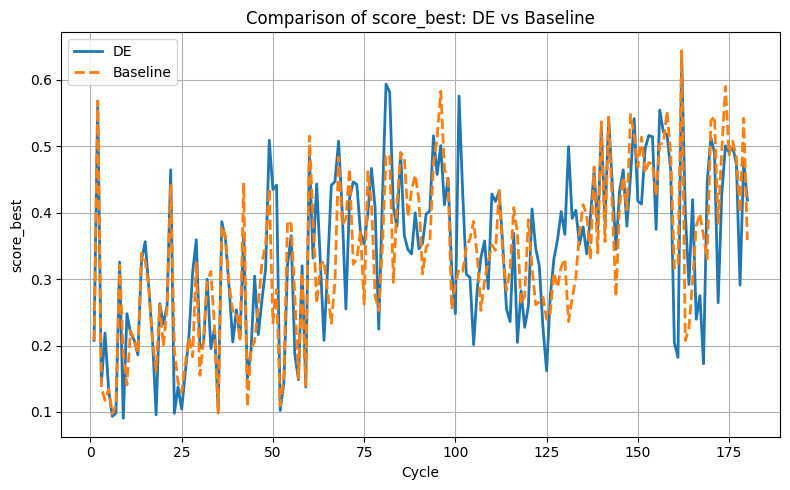

Average DE score_best: 0.3426
Average Baseline score_best: 0.3383
Δ Improvement: +0.0043 (1.26% change)
✅ DE improves over Baseline.


In [99]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_score_best(log_dir=LOG_DIR, baseline_prefix='traffic_baseline', de_prefix ='traffic_DE', baseline_suffix = "", de_suffix = ""):
    """
    Compare DE vs Baseline based on score_best over cycles.
    Shows a line plot and prints basic improvement summary.
    
    Parameters:
        de_path (str): Path to DE log CSV file
        baseline_path (str): Path to baseline log CSV file
    """
    de_path = os.path.join(log_dir, f"{de_prefix}_summary_{de_suffix}.csv")
    baseline_path = os.path.join(log_dir, f"{baseline_prefix}_summary_{baseline_suffix}.csv")
    if not os.path.exists(de_path):
        print(f"❌ Summary file not found: {de_path}")
        return
    if not os.path.exists(baseline_path):
        print(f"❌ Summary file not found: {baseline_path}")
        return
    # Load CSVs
    de = pd.read_csv(de_path)
    baseline = pd.read_csv(baseline_path)

    # Load the CSVs
    de = pd.read_csv(de_path)
    baseline = pd.read_csv(baseline_path)

    # Ensure same length / alignment
    min_len = min(len(de), len(baseline))
    de = de.head(min_len)
    baseline = baseline.head(min_len)

    # Plot comparison
    plt.figure(figsize=(8, 5))
    plt.plot(de["cycle"], de["score_best"], label="DE", linewidth=2)
    plt.plot(baseline["cycle"], baseline["score_best"], label="Baseline", linestyle="--", linewidth=2)
    plt.xlabel("Cycle")
    plt.ylabel("score_best")
    plt.title("Comparison of score_best: DE vs Baseline")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary stats
    mean_de = de["score_best"].mean()
    mean_base = baseline["score_best"].mean()
    diff = mean_de - mean_base

    print(f"Average DE score_best: {mean_de:.4f}")
    print(f"Average Baseline score_best: {mean_base:.4f}")
    print(f"Δ Improvement: {diff:+.4f} ({(diff / mean_base) * 100:.2f}% change)")

    if diff > 0:
        print("✅ DE improves over Baseline.")
    elif diff < 0:
        print("❌ DE performs worse than Baseline.")
    else:
        print("⚖️ DE and Baseline perform equally.")

compare_score_best(de_suffix='20251107_171335', baseline_suffix='20251107_171421')